# Time / precision

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

**Idée :** On se place ici dans un des cas tests proposés.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import time
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.despine(left=True)
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem import FEMSolver
from modules.utils import create_tree

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


<Figure size 640x480 with 0 Axes>

In [4]:
if testcase == 1:
    if version == 1:
        from modules.testcases.test_1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from modules.testcases.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from modules.testcases.test_2 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase2
    problem = TestCase2()
else:
    raise ValueError("Testcase not found")

result_dir = "../results/testcase"+str(testcase)
if version != 1:
    result_dir += "_v"+str(version)
result_dir += "/time_precision/"
create_tree(result_dir)

torch loaded; device is cuda


/home/flecourtier/Bureau/Article1
>> load network /home/flecourtier/Bureau/Article1/networks/test_fe1.pth
jsbdbshd
network loaded


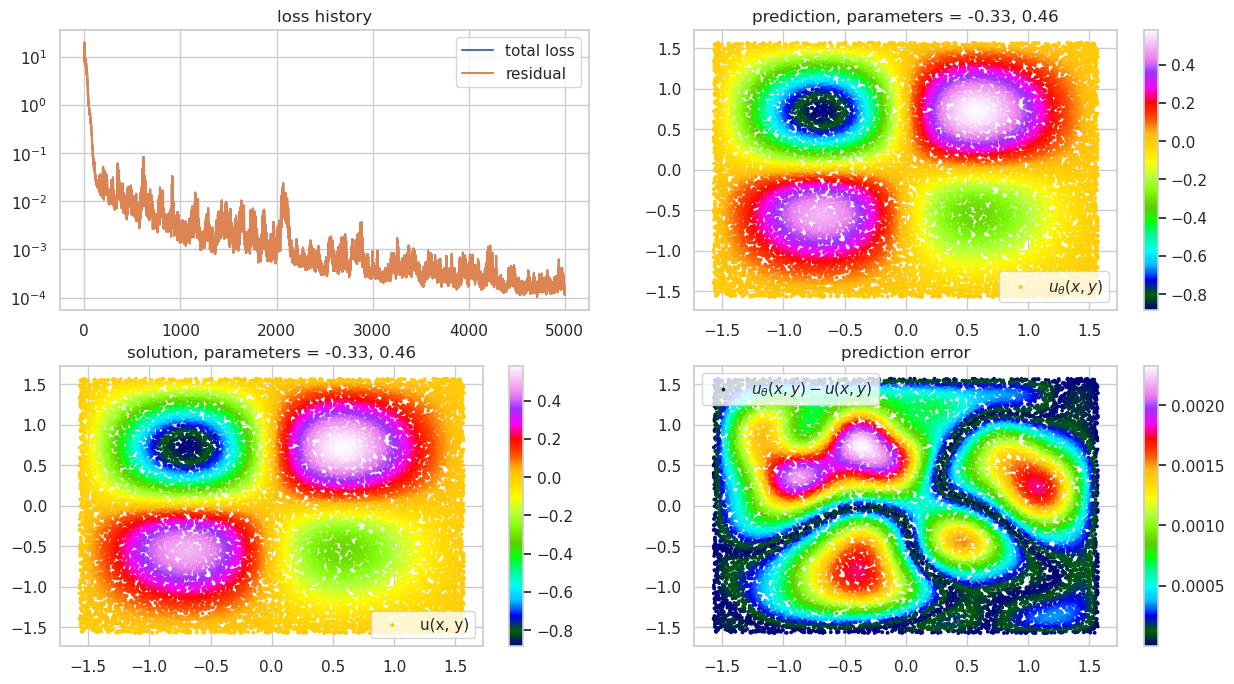

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22]


## Convergence FEM

In [7]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    tab_times_FEM = list(df_FEM['times'].values)
    tab_subtimes_FEM = {}
    for key in df_FEM.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_FEM[key] = list(df_FEM[key].values)
    
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(3,8)]
        tab_h_FEM = []
        tab_err_FEM = []
        tab_times_FEM = []
        tab_subtimes_FEM = {}

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            times_FEM = solver.times_fem
            for key in times_FEM:
                if key in tab_subtimes_FEM:
                    tab_subtimes_FEM[key].append(times_FEM[key])
                else:
                    tab_subtimes_FEM[key] = [times_FEM[key]]
            tab_times_FEM.append(sum(times_FEM.values()))
        
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM, 'times': tab_times_FEM, **tab_subtimes_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM

In [8]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM, tab_times_FEM, tab_subtimes_FEM = run_FEM(degree)

Read csv file ../results/testcase1/time_precision/FEM_case1_param1_degree1.csv


## Convergence PINNs+Corr

In [9]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [10]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    tab_times_Corr = list(df_Corr['times'].values)
    tab_subtimes_Corr = {}
    for key in df_Corr.keys():
        if key not in ['nb_vert', 'h', 'err', 'times']:
            tab_subtimes_Corr[key] = list(df_Corr[key].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [5*i for i in range(2,7)]
        tab_h_Corr = []
        tab_err_Corr = []
        tab_times_Corr = []
        tab_subtimes_Corr = {}

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            start = time.time()
            V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            end = time.time()
            
            time_get_u_PINNs = end - start
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            times_Corr = solver.times_corr_add
            times_Corr["get_u_PINNs"] = time_get_u_PINNs
            for key in times_Corr:
                if key in tab_subtimes_Corr:
                    tab_subtimes_Corr[key].append(times_Corr[key])
                else:
                    tab_subtimes_Corr[key] = [times_Corr[key]]
            tab_times_Corr.append(sum(times_Corr.values()))
            
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr, 'times': tab_times_Corr, **tab_subtimes_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr

In [11]:
degree = 1
df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr, tab_times_Corr, tab_subtimes_Corr = run_Corr(degree)

Read csv file ../results/testcase1/time_precision/Corr_case1_param1_degree1.csv


In [12]:
df_Corr

,nb_vert,h,err,times,mesh,assemble,solve,get_u_PINNs
0,10,0.493654,0.026173,0.159113,0.000065,0.134438,0.000341,0.024270
1,15,0.317349,0.011802,0.357692,0.000044,0.328977,0.000514,0.028158
2,20,0.233836,0.006597,0.679396,0.000043,0.626872,0.000714,0.051766
3,25,0.185120,0.004189,1.054540,0.000056,0.965378,0.000976,0.088130
4,30,0.153203,0.002889,1.519284,0.000070,1.394029,0.001635,0.123550


## Plots

In [13]:
print("subtimes FEM : ", tab_subtimes_FEM)
print("subtimes Corr : ", tab_subtimes_Corr)

subtimes FEM :  {'mesh': [0.000157356262207, 4.172325134277344e-05, 7.677078247070312e-05, 0.0002074241638183, 0.0007832050323486], 'assemble': [0.0849161148071289, 0.3761000633239746, 1.613973617553711, 6.579207181930542, 26.930355072021484], 'solve': [0.0005946159362792, 0.0005495548248291, 0.0033376216888427, 0.0110542774200439, 0.0421168804168701]}
subtimes Corr :  {'mesh': [6.461143493652344e-05, 4.363059997558594e-05, 4.315376281738281e-05, 5.626678466796875e-05, 7.033348083496094e-05], 'assemble': [0.1344377994537353, 0.3289768695831299, 0.6268718242645264, 0.9653778076171876, 1.394028663635254], 'solve': [0.0003414154052734, 0.0005137920379638, 0.0007143020629882, 0.0009763240814208, 0.0016350746154785], 'get_u_PINNs': [0.0242695808410644, 0.0281577110290527, 0.0517663955688476, 0.0881295204162597, 0.1235504150390625]}


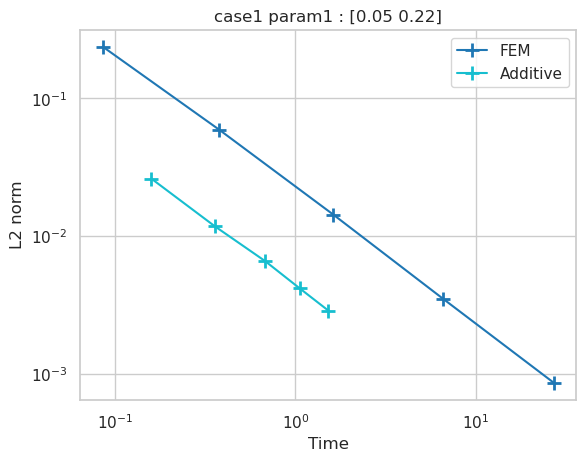

In [14]:
colors = ["tab:blue","tab:red","tab:cyan","tab:orange"]

plt.figure()

def plot_values(times,norms,color,label):
    plt.loglog(times,norms,"+-",color=color,label=label,markersize=10,markeredgewidth=2)

plot_values(tab_times_FEM,tab_err_FEM,colors[0],"FEM")
# plot_values(times_phifem,norms_phifem,colors[1],"PHIFEM")

plot_values(tab_times_Corr,tab_err_Corr,colors[2],"Additive")
# plot_values(times_corr_add_phifem,norms_corr_add_phifem,colors[3],"Corr_add_PHIFEM")

plt.xlabel("Time")
plt.ylabel("L2 norm")

plt.legend()
plt.title(f'case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f"time_precision_param{param_num}_degree{degree}.png")

## Tableau

In [20]:
tab_subtimes_FEM["get_u_PINNs"] = None
methods = ["FEM","Corr_FEM"]
steps = ["mesh","get_u_PINNs","assemble","solve","TOTAL"]

norms = {"FEM":tab_err_FEM,"Corr_FEM":tab_err_Corr}
subtimes = {"FEM":tab_subtimes_FEM,"Corr_FEM":tab_subtimes_Corr}
times = {"FEM":tab_times_FEM,"Corr_FEM":tab_times_Corr}

for method in methods:
    subtimes[method]["TOTAL"] = times[method]

###
# Interpolation
###

def get_index(norms,given_precision):
    norms = np.array(norms)
    if given_precision < norms[-1]:
        index = len(norms)-1
    elif given_precision > norms[0]:
        index = 0
    else:           
        index = np.where(norms < given_precision)[0][0]
    
    return index

def linear_interpolation(norms,times,index):
    norms = np.array(norms)
    times = np.array(times)
    
    norm = norms[index-1:index+1]
    time = times[index-1:index+1]

    t_inter = time[0]+(time[1]-time[0])/(norm[1]-norm[0])*(given_precision-norm[0])
    
    return t_inter

def get_time(given_precision):
    times_inter = {}
    for method in methods:
        times_inter[method] = {}
        for key in steps:
            if not subtimes[method][key] is None:
                index = get_index(norms[method],given_precision)
                t_inter = linear_interpolation(norms[method],subtimes[method][key],index)
                times_inter[method][key] = t_inter
            else:
                times_inter[method][key] = None
    return times_inter

In [23]:
given_precision = 1e-3
times_inter = get_time(given_precision)
# Create a dataframe with the times interpolated
df_given_precision = pd.DataFrame.from_dict(times_inter).T
# réorganiser lignes et colonnes par clés
df_given_precision = df_given_precision.reindex(methods)
df_given_precision = df_given_precision[steps]
# Create an excel file with the times

df_given_precision

,mesh,get_u_PINNs,assemble,solve,TOTAL
FEM,0.000754,NaN,25.886933,0.040524,25.928211
Corr_FEM,0.000091,0.175033,2.017048,0.002593,2.194764


In [24]:
pre = int(np.log10(given_precision))
result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

df_given_precision.to_excel(result_file+'.xlsx')

df_styled = df_given_precision.style.format("{:.2e}")
dfi.export(df_styled,result_file+".png",dpi=1000)

In [25]:
given_precision = 1e-4
times_inter = get_time(given_precision)
# Create a dataframe with the times interpolated
df_given_precision = pd.DataFrame.from_dict(times_inter).T
# réorganiser lignes et colonnes par clés
df_given_precision = df_given_precision.reindex(methods)
df_given_precision = df_given_precision[steps]
# Create an excel file with the times

df_given_precision

,mesh,get_u_PINNs,assemble,solve,TOTAL
FEM,0.000950,NaN,32.818683,0.051104,32.870737
Corr_FEM,0.000101,0.199555,2.313812,0.003049,2.516516


In [26]:
pre = int(np.log10(given_precision))
result_file = result_dir+f'times_table_param{param_num}_degree{degree}_1e{pre}'

df_given_precision.to_excel(result_file+'.xlsx')

df_styled = df_given_precision.style.format("{:.2e}")
dfi.export(df_styled,result_file+".png",dpi=1000)